# Análisis del SMP - BM5Z1

Este análisis de datos inicial permite ver **distribuciones de frecuencias** muy útiles para una primera exploración.

## Resumen

- Muestra información del SMP de los últimos **12 meses** para la zona **BM5Z1**, sólo APP, APE y APF. 
- Hubo una parada que duró **7 horas**, del Q0 mesa de rolos.
- Hay **236 horas** de parada total acumulada entre todos los módulos.
- El **75%** de las paradas duró **menos de 1 minuto**.
- El **95%** de la duración total de paradas está formada por **6989** paradas, que es un **48.79%** del total.
- Hay **114** paradas que duraron entre **10 y 100** minutos.
- El robot que *más veces* falló fue el **R4**.
- El que *más tiempo* de parada acumuló fue **T5**, con un promedio de 1 minuto.


*Para un modelo de mantenimiento predictivo es información necesaria pero no suficiente.*

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="darkgrid")


In [47]:
df = pd.read_csv('C:\\Users\\pm24641\\OneDrive - Alliance\\Recursos PF\\BM5Z1.csv')

# Resumen de Datos

Se muestra una tabla con las **10 paradas más largas del período**.


In [48]:
sorted_data = df[df['Duration'] > 0].sort_values(by='Duration', ascending=False)
df['Duration_minutes'] = df['Duration'] / 60

total_duration = sorted_data['Duration'].sum() / 60
total_duration_h = total_duration / 60
print("Zona:  4301 - BM5Z1")
print(f'Cantidad total de paradas: {len(df)}')
print(f'Duración de todas las paradas en los últimos 12 meses: {total_duration:.2f} minutos, o {total_duration_h:.2f} horas')

sorted_data['cumulative_duration'] = sorted_data['Duration'].cumsum() /60

percentages = [50, 80, 95]
thresholds = {p: sorted_data[sorted_data['cumulative_duration'] <= total_duration * (p / 100.0)] for p in percentages}

insight_data = {p: len(thresholds[p]) for p in percentages}
total_stops = len(df)
percentage_stops = {p: (insight_data[p] / total_stops * 100) for p in percentages}

for p in percentages:
    print(f'El {p}% de la duración total de paradas está formada por {insight_data[p]} paradas, que es un {percentage_stops[p]:.2f}% del total.')


top= 10
top_stops = df.nlargest(top, 'Duration')
columns_to_display = [
    'Horodate', 'Type', 'Duration_minutes', 'Module', 'Fine location', 'Stop cause',
    'Comment', 'Event', 'Stops family', 'Stops under-family', 'Variety mnemo'
]

top_stops = top_stops[columns_to_display]

print(f"Top {top} paradas por duración (minutos):")
display(top_stops.style.set_table_attributes('style="font-size: 12px; width:100%"')
                      .bar(subset=['Duration_minutes'], color='#d65f5f').format({'Duration_minutes': "{:.2f}"}))




Zona:  4301 - BM5Z1
Cantidad total de paradas: 14325
Duración de todas las paradas en los últimos 12 meses: 14159.97 minutos, o 236.00 horas
El 50% de la duración total de paradas está formada por 995 paradas, que es un 6.95% del total.
El 80% de la duración total de paradas está formada por 3205 paradas, que es un 22.37% del total.
El 95% de la duración total de paradas está formada por 6989 paradas, que es un 48.79% del total.
Top 10 paradas por duración (minutos):


,Horodate,Type,Duration_minutes,Module,Fine location,Stop cause,Comment,Event,Stops family,Stops under-family,Variety mnemo
3921,2023-12-22 14:23:00,APP,452.98,10 - Q0 - Q0 mesa de rolos,nan,Z1: Q0 Def. movimiento plataforma operador,nan,Z1: Q0 Def. movimiento plataforma operador,nan,nan,F67
3922,2023-12-22 10:34:11,APP,198.82,10 - Q0 - Q0 mesa de rolos,nan,Z1: Q0 Def. movimiento plataforma operador,nan,Z1: Q0 Def. movimiento plataforma operador,nan,nan,F67
11612,2023-06-13 06:18:11,APE,102.12,0 - COM1 - GLOBAL ZONE,Conjunto proteccion,Corte seguridad involuntario,defecto FM2,Z1: Perdida marcha automatica zona,PARADA GEN. Y EXPLOTACION,Parada OPERARIO,nan
11103,2023-09-28 08:52:26,APP,67.72,32 - T2RBPOINT - T2 Robot Sold. por puntos,Cambiador pinza,Detector (Sustitución),Colision pinza 1 a pinza 2,STOP,AUTOMATISMOS,CAPTADOR ESPECIALISTA,XNQ
4190,2023-12-15 13:21:13,APE,56.78,10 - Q0 - Q0 mesa de rolos,paleta_Luge,Otra Parada de explotacion,parada programada para refrigerio,Z1: Q0 Def. movimiento plataforma operador,PARADA GEN. Y EXPLOTACION,PARADA EXPLOTACION,XNQ
8428,2023-08-25 12:29:00,APE,50.22,10 - Q0 - Q0 mesa de rolos,Conjunto control visión,Otra Parada de explotacion,asamblea,Z1: Q0 Def. movimiento plataforma operador,PARADA GEN. Y EXPLOTACION,PARADA EXPLOTACION,XNQ
8808,2023-04-18 21:52:34,APP,43.43,36 - T6RBPOINT - T6 Robot Sold. por puntos,General Ejes,Perdida de calibración eje robot,"def contador de revoluciones , def encoder",Z1: T6 Defecto robot,ROBOT,HARD BAIE_PC,F67
8516,2023-08-23 20:26:09,APE,42.13,20 - R0 - R0 mesa de rolos,Conjunto mesa de rodillos,Otra Parada de explotacion,sin def,Z1: Q0 Def. movimiento plataforma operador,PARADA GEN. Y EXPLOTACION,PARADA EXPLOTACION,nan
791,2024-04-18 21:29:24,APE,37.58,0 - COM1 - GLOBAL ZONE,nan,Z1: Perdida de marcha de ciclo de zona,nan,Z1: Perdida de marcha de ciclo de zona,nan,nan,nan
13679,2023-11-13 08:05:31,APF,35.90,31 - T1RBPOINT - T1 Robot Sold. por puntos,Pinza embarcada 1,Prueba mantenimiento,def temperatura de dispexterno excesiva,Z1: T1 Defecto robot,Parada FUNCIONALES,MANTENIMIENTO,nan


## Análisis en el tiempo

Mediante el siguiente gráfico de paradas semanales, se puede visualizar la duración total y frecuencia de paradas.

Utiliza media móvil para suavizar la serie.

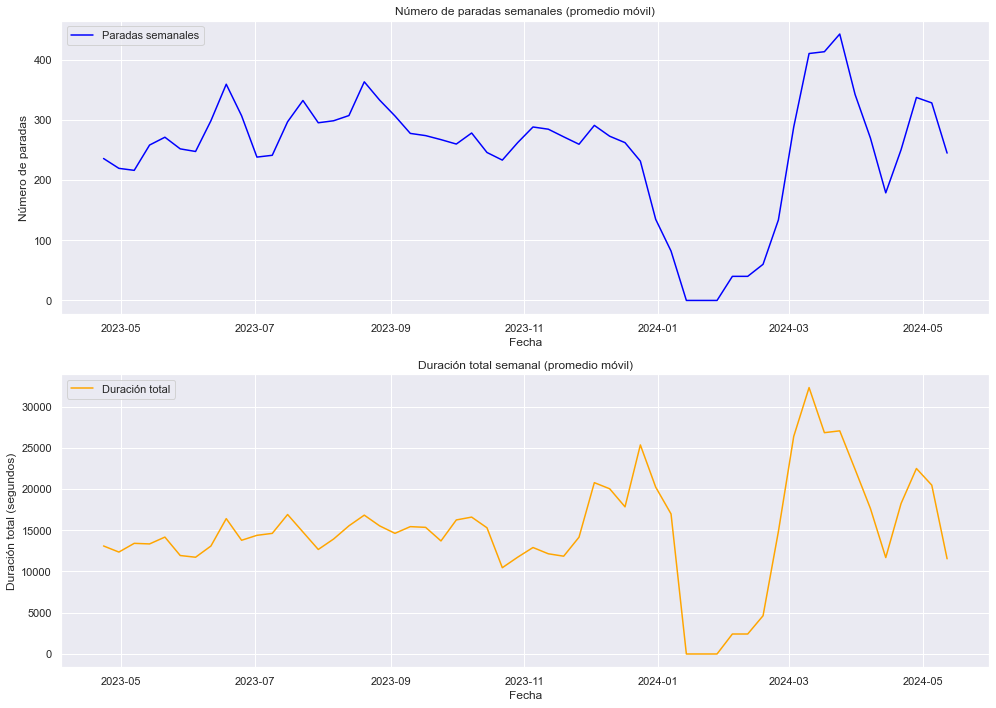

In [49]:
df['Horodate'] = pd.to_datetime(df['Horodate'])
# Resample to weekly intervals and aggregate stops and downtime
weekly_analysis = df.resample('W', on='Horodate').agg(
    weekly_stops=('Duration', 'count'),
    weekly_downtime=('Duration', 'sum')
).reset_index()

# Apply rolling averages to smooth the data (window size of 3)
weekly_analysis['smooth_stops'] = weekly_analysis['weekly_stops'].rolling(window=3).mean()
weekly_analysis['smooth_downtime'] = weekly_analysis['weekly_downtime'].rolling(window=3).mean()

# Create two subplots to separate stops and downtime
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot smoothed stops on the first subplot
sns.lineplot(x='Horodate', y='smooth_stops', data=weekly_analysis, ax=ax1, color='blue', label='Paradas semanales')
ax1.set_title('Número de paradas semanales (promedio móvil)')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Número de paradas')
ax1.legend(loc='upper left')
ax1.grid(visible=True)

# Plot smoothed downtime on the second subplot
sns.lineplot(x='Horodate', y='smooth_downtime', data=weekly_analysis, ax=ax2, color='orange', label='Duración total')
ax2.set_title('Duración total semanal (promedio móvil)')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Duración total (segundos)')
ax2.legend(loc='upper left')
ax2.grid(visible=True)

fig.tight_layout()
plt.show()

# Histograma

Para entender cómo se distribuyen las paradas, podemos hacer un histograma. Está dividido por rangos de duración, entre 0 y 1 minuto, 1 y 10 minutos, y 10 y 460 minutos. Incluye a todas las paradas.

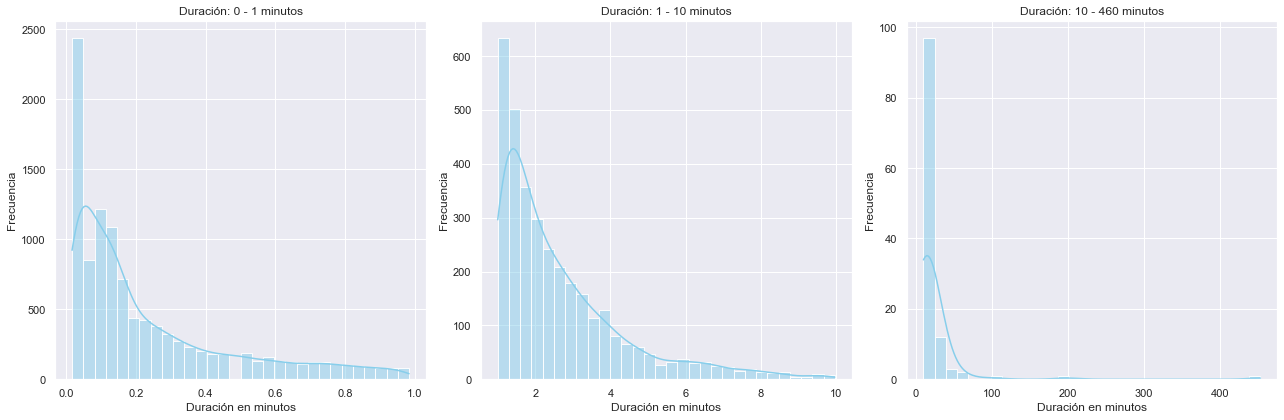

In [50]:
filtered_duration = df[df['Duration'] > 0]['Duration'] / 60

ranges = [
    (0, 1),    
    (1, 10),   
    (10, 460), 
]

fig, axes = plt.subplots(1, len(ranges), figsize=(18, 6))

for ax, (lower, upper) in zip(axes, ranges):
    subset = filtered_duration[(filtered_duration >= lower) & (filtered_duration < upper)]
    sns.histplot(subset, kde=True, bins=30, color='skyblue', ax=ax)
    ax.set_title(f'Duración: {lower} - {upper} minutos')
    ax.set_xlabel('Duración en minutos')
    ax.set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()


# Lo más común

En los siguientes 10 gráficos se ven los problemas más comunes, los robots que más fallan, los tipos de erorres más comunes, y más detalles.
Es útil para conocer dónde podemos poner el foco.


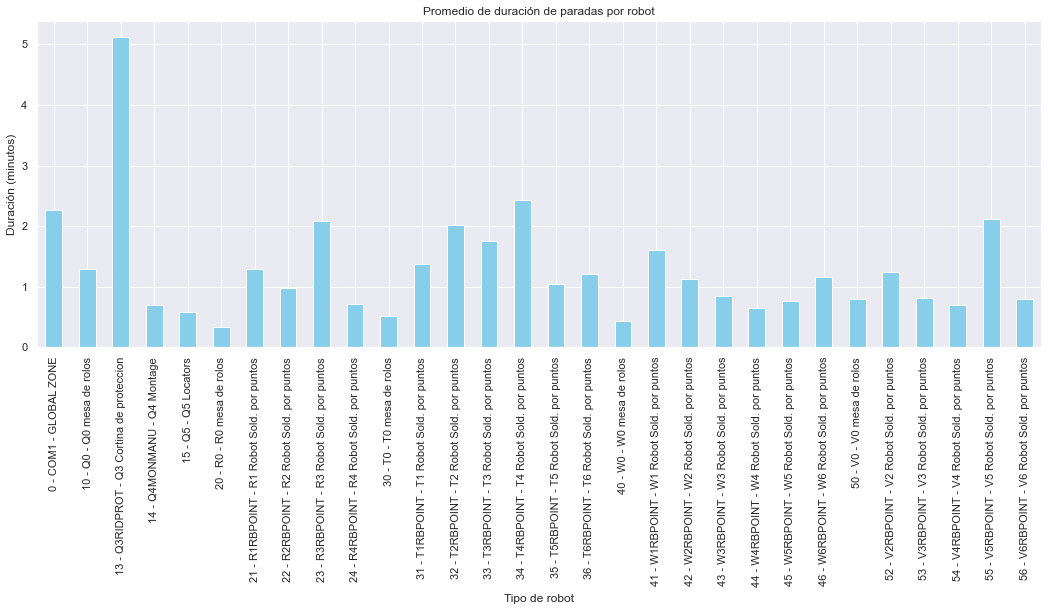

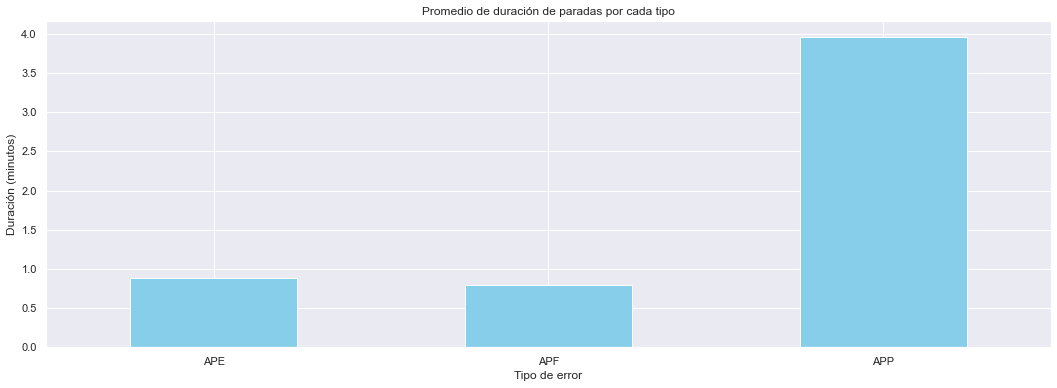

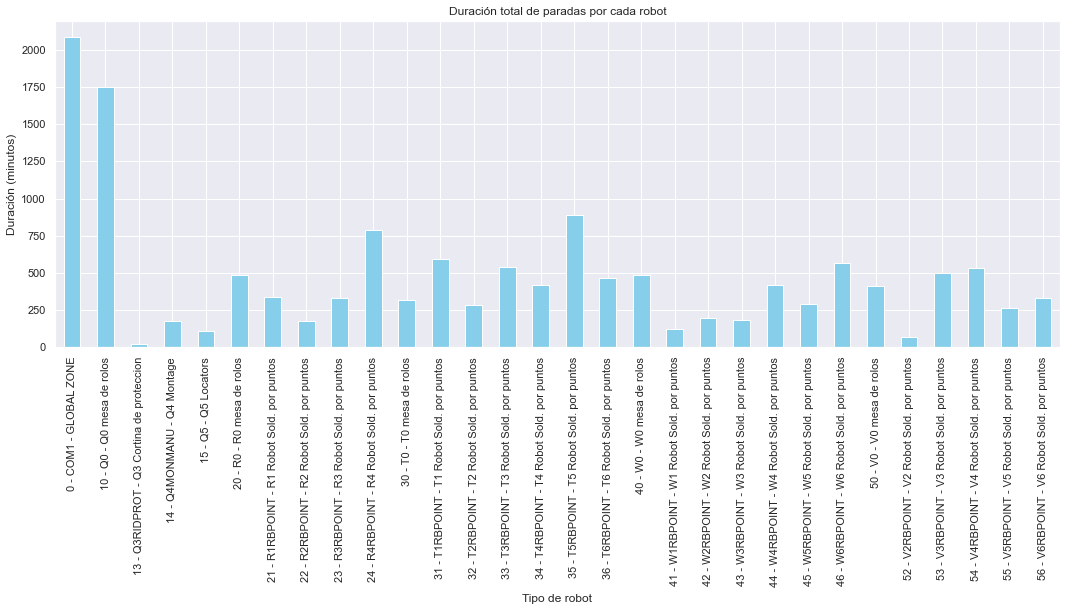

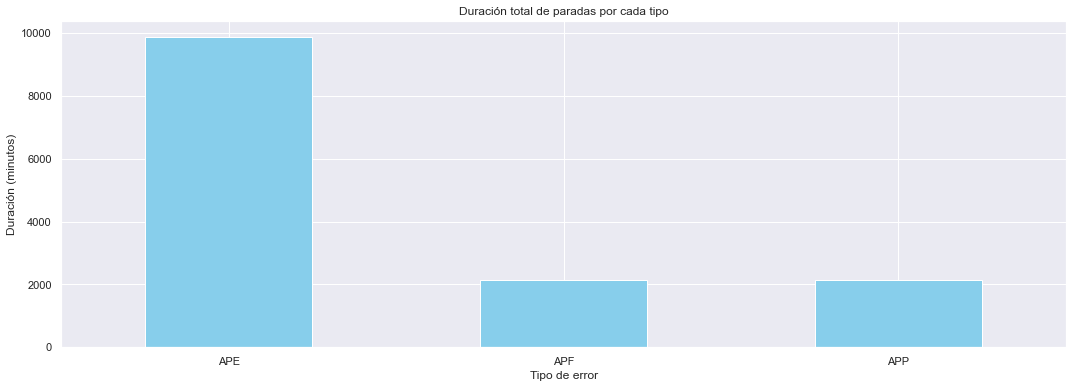

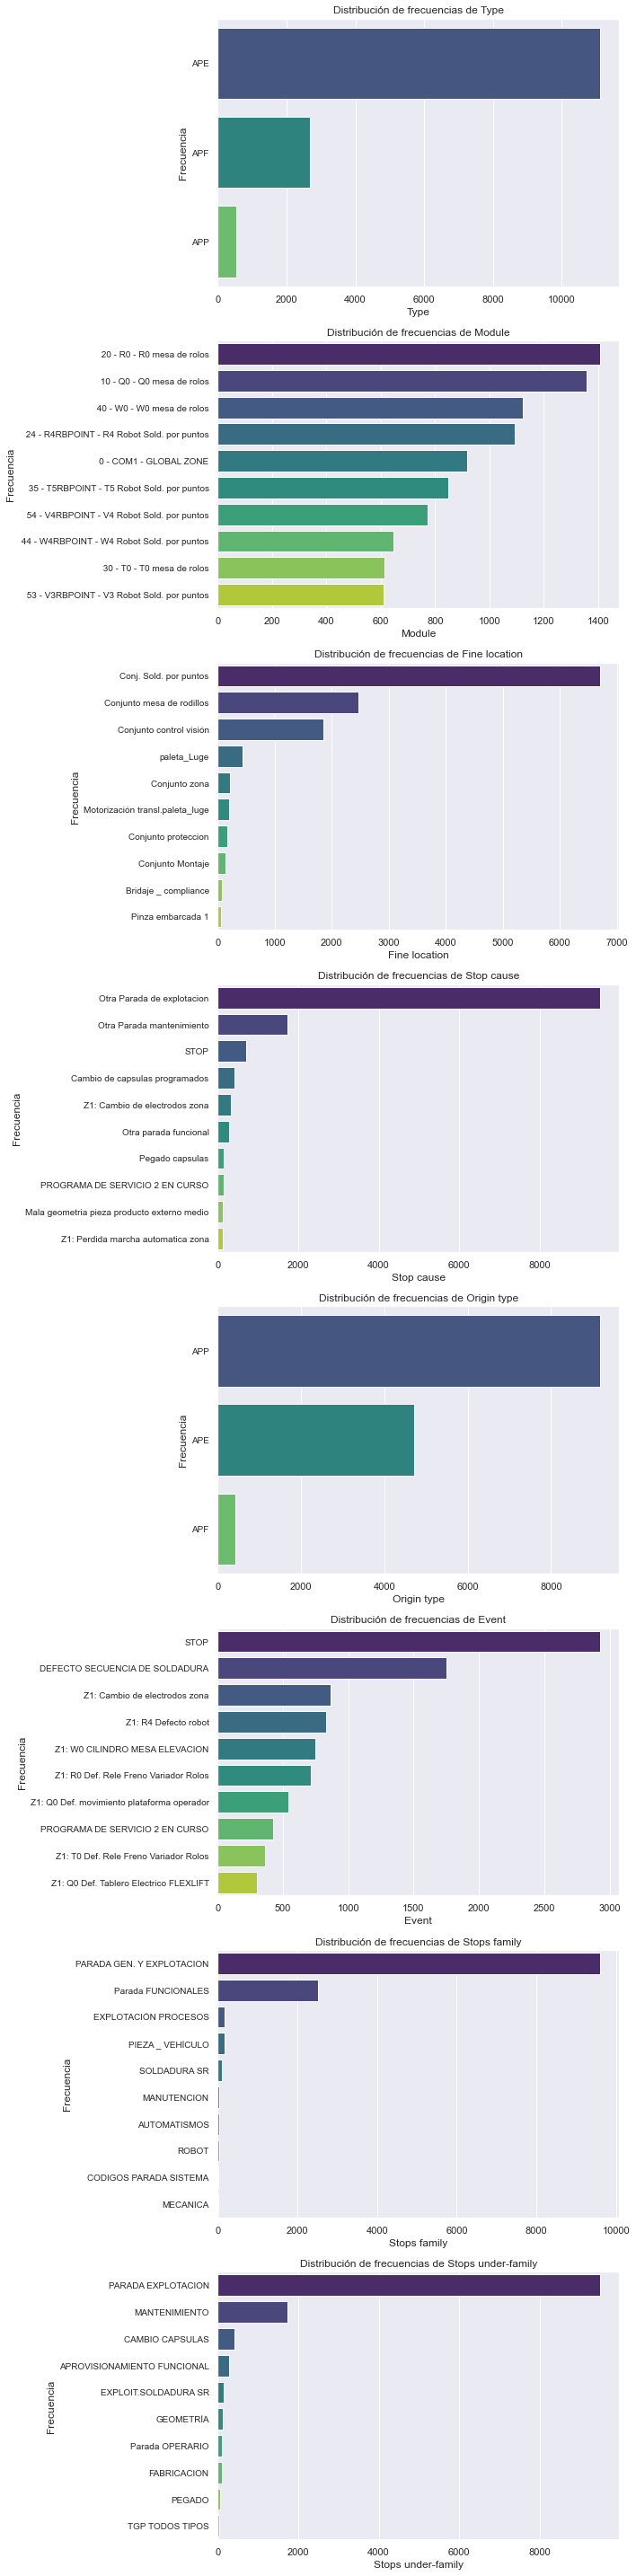

In [51]:
robot_duration = df.groupby('Module')['Duration'].sum() / 60

average_robot_duration = df.groupby('Module')['Duration'].mean() / 60

type_duration = df.groupby('Type')['Duration'].sum() / 60

average_type_duration = df.groupby('Type')['Duration'].mean() / 60

plt.figure(figsize=(18,6))
average_robot_duration.plot(kind='bar',color='skyblue')
plt.title('Promedio de duración de paradas por robot')
plt.xlabel('Tipo de robot')
plt.ylabel('Duración (minutos)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(18, 6))
average_type_duration.plot(kind='bar', color='skyblue')
plt.title('Promedio de duración de paradas por cada tipo')
plt.xlabel('Tipo de error')
plt.ylabel('Duración (minutos)')
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(18, 6))
robot_duration.plot(kind='bar', color='skyblue')
plt.title('Duración total de paradas por cada robot')
plt.xlabel('Tipo de robot')
plt.ylabel('Duración (minutos)')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(18, 6))
type_duration.plot(kind='bar', color='skyblue')
plt.title('Duración total de paradas por cada tipo')
plt.xlabel('Tipo de error')
plt.ylabel('Duración (minutos)')
plt.xticks(rotation=0)
plt.show()

columns_to_plot = ['Type', 'Module', 'Fine location', 'Stop cause', 'Origin type', 'Event', 'Stops family', 'Stops under-family']

fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 5 * len(columns_to_plot)))

if len(columns_to_plot) == 1:
    axes = [axes]

for i, col in enumerate(columns_to_plot):
    data = df[col].value_counts().nlargest(10)
    sns.barplot(x=data.values, y=data.index, ax=axes[i], palette='viridis', orient='h')
    axes[i].set_title(f'Distribución de frecuencias de {col}')
    axes[i].set_ylabel('Frecuencia')
    axes[i].set_xlabel(f'{col}')
    axes[i].tick_params(axis='y', which='major', labelsize=10)
    plt.subplots_adjust(left=0.3) 

plt.tight_layout()
plt.show()

# Análisis para T3

A continuación podemos ver un análisis más profundo para el robot **T3**, sólo defectos **APP**. Todavía el último gráfico está en desarrollo y no presenta información fiable.

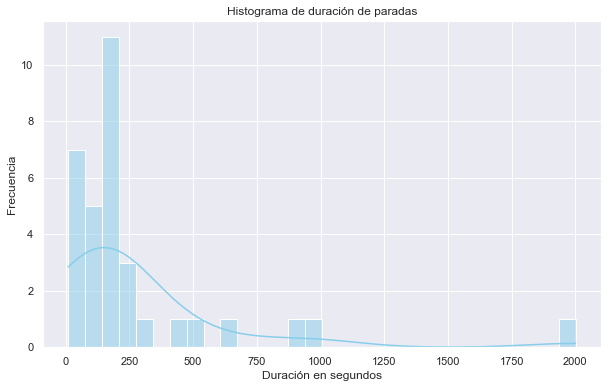

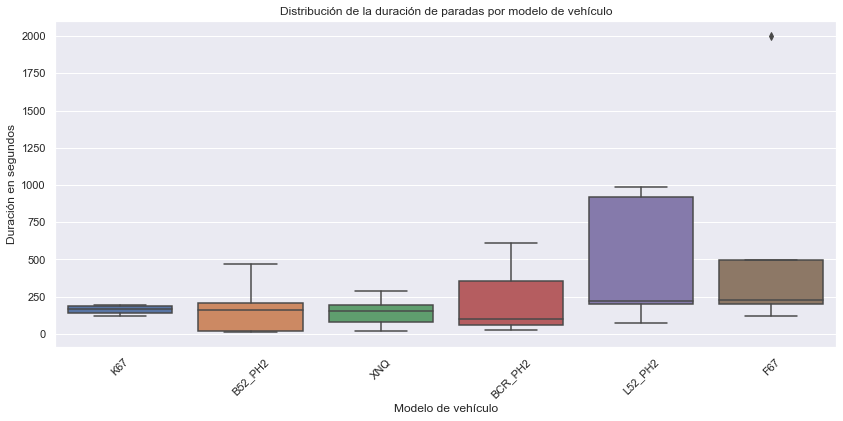

In [52]:
df.loc[df['Module'] == " 33 - T3RBPOINT - T3 Robot Sold. por puntos", 'Horodate'] = pd.to_datetime(
    df.loc[df['Module'] == " 33 - T3RBPOINT - T3 Robot Sold. por puntos", 'Horodate'],
    format="%Y-%m-%d %H:%M:%S",
    errors='coerce'
)

# Extract filtered data again
module_data = df[(df['Module'] == " 33 - T3RBPOINT - T3 Robot Sold. por puntos")&(df['Type']=="APP")]
grouped_by_vehicle = module_data.groupby('Variety mnemo').agg(
    total_stops=('Duration', 'count'),
    total_downtime=('Duration', 'sum')
).reset_index()
plt.figure(figsize=(10, 6))
sns.histplot(module_data['Duration'], kde=True, bins=30, color='skyblue')
plt.title('Histograma de duración de paradas')
plt.xlabel('Duración en segundos')
plt.ylabel('Frecuencia')
plt.show()

# Box plot for stop durations by vehicle model
plt.figure(figsize=(14, 6))
sns.boxplot(x='Variety mnemo', y='Duration', data=module_data)
plt.xticks(rotation=45)
plt.title('Distribución de la duración de paradas por modelo de vehículo')
plt.xlabel('Modelo de vehículo')
plt.ylabel('Duración en segundos')
plt.show()